# Word Window Classification and Neural Networks

## Background - Cross Entropy
It's good to explain what is cross entropy despite that we have seen it and used it many times. The entropy is measuring the disorder or non-uniformity of two probability distributions. Which two? We have one for probability distribution from the model we are training and one probability distribution from the training labels. 

We have a ground truth probability distribution from label data. 
```python
p = [0, 0, 0, ..., 1, ..., 0]
```

Our computed probability is `q[c]` for a given class `c`. Then we can say that cross entropy is the following.
$$
H(p, q) = -\Sigma_{c=1}^{C} p(c)\;log\;q(c)
$$

**Before p is an one-hot vector, the only term left is the negative probability of the true class.** The objective function is trying to minimize the Kullback-Leibler divergence between the two distributions.

In [1]:
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np

num_classes = 10
y = 4

true_dist = signal.unit_impulse(num_classes, y)
rand_dist = np.random.rand(10,)
plt.plot(np.arange(0, 10), true_dist, '-o', rand_dist, '-o')
plt.show()

print 'cross entropy: %f' % (-1 * np.log(rand_dist[y]))

<Figure size 640x480 with 1 Axes>

cross entropy: 0.327756


## Classification: Regularization
Also don't forget the regularization term because it is essential to prevent overfitting, plus it is not a difficult thing to incorporate into a training objective.
$$
J(\theta) = \frac{1}{N}\Sigma^{N}_{i=1} -log\left(P(f_{y[i]})\right) + \lambda \Sigma_{k} \theta^{2}_{k}
$$

##  Re-training Word Vectors
* If you only have a small training data set, don't train the word vectors.
* If you have a very large dataset, it may work better to train word vectors the task.

## Window Classification

### Ambuigity
Classifying a single word is rarely done this is because the meaning of a word varies depending on context. There is a lot of ambiguity to a single word.

**Example**: auto-antonyms
* "To sanction" can mean "to permit" or "to punish"
* "To seed" can mean "to place seeds" or "to remove seeds"

**Example**: ambiguous named entities
* Paris could mean Paris, France or Paris Hilton
* Hathaway could mean Berkshire Hathaway or Anne Hathaway

### Idea
We want to classify a word in its context window of neighboring words. For example, named dentity recognition can be classified into four classes.
* Person, location, organization and none

There are many possibilities for classifying one word in context, e.g. averaging all the words in a window but that loses position information. We will train a softmax classifier by assigning a label to a center word and concatenating all word vectors surrounding it.

**Example**: classify Paris in the context of this sentence with window length 2.
$$
X_{window} = \left[ x_{museums}, x_{in}, x_{Paris}, x_{are}, x_{amazing} \right]
$$

The resulting vector is of length `5*D` where `D` is the word vector dimension.

### Implementation
Before we implement anything, let's define the terminology concretely here.

We use y hat to denote the prediction.
$$
\hat{y}: \text{softmax probability output vector}
$$

Target probability distribution is the ground truth vector. All 0's except ground truth index where it's 1.
$$
t: \text{target probability distribution}
$$

We use simple affine transformation to feed forward. 
$$
f = f(x) = xW
$$

In [2]:
import numpy as np

corpus = "Calvin and Carmen are going to Korea soon".split()
# Define couple dimension variables
# N for number of windows, C for number of classes, and D for vector dimension for each window.
C = 4
D = 300
N = len(corpus)

# I go through each word of the corpus and generate a random word vector for it.
V = dict()
for word in corpus:
    V[word] = np.random.randn(D)

The general rule of thumb is that, use word to random vec when the dataset is small, use Skip-gram model word to vec when dataset is huge. Now we are can slide across the whole corpus and create windows. I will use zero vectors to represent the words that do not exist or for the portion of the window that is out of bound.

In [3]:
X = []
for i in range(len(corpus)):
        vecs = []
        for j in range(i - 2, i + 3):
            if j < 0 or len(corpus) <= j:
                vecs.append(np.zeros((D)))
            else:
                vecs.append(V[corpus[j]])
        
        X.append(np.concatenate(tuple(vecs), 0))

X = np.array(X)

Now we have a `(N, 5D)` tensor, where N is the number of windows and D is the word vector dimension for an individual word. We now just need to define a weight and perform feedforward operation on it. Let's first define the numerically stable softmax probability function.

In [4]:
def stable_probability(x):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    return np.exp(shifted_logits) / Z

W = np.random.rand(5*D, C)
f = np.dot(X, W)
y = stable_probability(f) # This is the final output of the model, a matrix of softmax probability.

## Backpropagations
We have done this many times already. I will just take the code from my other project and use it here. Let's assume that the ground truth distribution is the following. I will use the letter `t` to denote target distribution or target label etc...

In [5]:
# Four classes: person, location, organization, and none
t = np.array([[1, 0, 0, 0],
            [0, 0, 0, 1],
            [1, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 1],
            [0, 0, 0, 1],
            [0, 1, 0, 0],
            [0, 0, 0, 1]])

# Let's compute the loss first.
def categorical_cross_entropy(y_pred, y):
    """Computes categorical cross entropy loss.
    Args:
        y_pred (numpy.ndarray): Output of the network, of shape (N, C) where x[i, j] is the softmax 
                                probability for for jth class for the ith input.
        y (numpy.ndarray): Vector of labels in one-hot representation.
    Returns:
        loss (float): Scalar value of the cross entropy loss.
    """
    N = len(y_pred)
    y = np.argmax(y, axis=1)
    log_probs = np.log(y_pred)

    return -1 * np.sum(log_probs[np.arange(N), y]) / N

print 'Cross entropy loss is %f' % categorical_cross_entropy(y, t)

Cross entropy loss is 7.197643


Now we are ready to do backpropagation and reduce minimize this loss value.

In [6]:
# Compute gradient of f
grad_f = y.copy()
grad_f[np.arange(N), np.argmax(t, axis=1)] -= 1
grad_f /= N
print grad_f.shape # (N, C)

grad_W = np.dot(X.T, grad_f) # (D, N)(N, C) => (D, C)
print grad_W.shape # (D, C)

(8, 4)
(1500, 4)


Now put everything together and run 100 iterations on it.

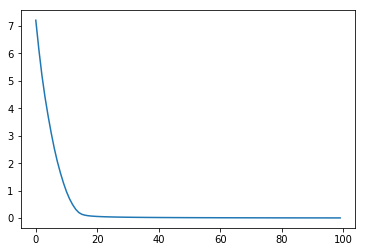

In [7]:
loss_history = []
for i in range(100):
    # Forward
    f = np.dot(X, W)
    y = stable_probability(f)
    loss_history.append(categorical_cross_entropy(y, t))
    
    # Backprop
    grad_f = y.copy()
    grad_f[np.arange(N), np.argmax(t, axis=1)] -= 1
    grad_f /= N
    grad_W = np.dot(X.T, grad_f)
    
    # Weight update
    W -= 5e-3 * grad_W

plt.plot(np.arange(100), loss_history)
plt.show()

## Max-Margin Loss
This loss is often more robust and more powerful than cross entropy loss for our task here. The training objective is to make score of true window larger and score of corrupt window lower. 
$$
J = max(0, 1 - s + s_{c})
$$

For example,
```python
s = score("museums in Paris are amazing") 
s_c = score("Not all museums in Paris") # corrupted window
```

We want to give the window where the center word is a location a higher score than the window where the center word is NOT a location. This is essentially a **hinge loss**. We sample several corrupt windows per true one. Sum over all training windows. The corrupt window is just a negative class.

### Gradient
Actually the gradient of a hinge loss is very similar to that of **ReLU**. It's an on/off gate. Suppose that we group the positive and negative class score together and call it delta s.
$$
\Delta s = 1 - s + s_{c}
$$

Then the loss function is simply.
$$
J = max(0, \Delta s)
$$

If delta s is greater than zero, then the gradient is 1.
$$
\frac{\partial J}{\partial \Delta s} = 1
$$

Else it is zero.
$$
\frac{\partial J}{\partial \Delta s} = 0
$$
